In [319]:
# =========================================================
# Paper Figures: CE + (R)CSI with Unicycles, Baselines, Bands
# Figures:
# 1) Homogeneous
# 2) Heterogeneous (eps_var > 0)
# 3) Heterogeneous + Byzantine (robust aggregation)
# 4) Misclassification (Homogeneous)
# 5) Aggregation comparison (trimmed vs geometric median)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from itertools import permutations
import datetime
# ------------------ formatting defaults ------------------
BIG = 16
MID = 14
SML = 12

def stylize_axes(ax, title=None, ylabel=None, xlabel=None, bold_title=True, bold_ylabel=True):
    if title is not None:
        ax.set_title(title, fontsize=BIG, fontweight=('bold' if bold_title else 'normal'))
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=MID, fontweight=('bold' if bold_ylabel else 'normal'))
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=MID)
    ax.grid(True, alpha=0.35)
    ax.tick_params(labelsize=SML)

# ------------------ utilities ------------------

def align_labels_best_perm(pred_labels: np.ndarray,
                           true_labels: np.ndarray,
                           K: int):
    C = np.zeros((K, K), dtype=int)
    for j in range(K):
        for k in range(K):
            C[j, k] = np.sum((pred_labels == j) & (true_labels == k))
    best_p, best_score = None, -1
    for p in permutations(range(K)):
        score = sum(C[j, p[j]] for j in range(K))
        if score > best_score:
            best_score, best_p = score, np.array(p, dtype=int)
    remapped = best_p[pred_labels]
    mis = int(np.sum(remapped != true_labels))
    return remapped, mis, best_p

def spectral_radius(A):
    return float(np.max(np.abs(np.linalg.eigvals(A))))

# ------------------ prototypes & systems (Unicycle) ------------------

def get_prototypes_from_paper():
    """
    Three different unicycle models (discrete-time Euler linearization).
    States: [x, y, θ], Inputs: [v, ω].
    """
    def unicycle_AB(v0, theta0, dt=0.1):
        A = np.array([
            [0, 0, -v0 * np.sin(theta0)],
            [0, 0,  v0 * np.cos(theta0)],
            [0, 0, 0]
        ], dtype=float)
        B = np.array([
            [np.cos(theta0), 0],
            [np.sin(theta0), 0],
            [0, 1]
        ], dtype=float)
        A_d = np.eye(3) + dt * A
        B_d = dt * B
        return A_d, B_d

    configs = [
        (1.0, np.deg2rad(0.0),  0.1),  # heading 0°, speed 1.0
        (1.0, np.deg2rad(45.0), 0.1),  # heading 45°, speed 1.0
        (0.8, np.deg2rad(90.0), 0.1),  # heading 90°, speed 0.8
    ]
    A_list, B_list = [], []
    for v0, th0, dt in configs:
        A, B = unicycle_AB(v0, th0, dt)
        A_list.append(A); B_list.append(B)
    return A_list, B_list

def make_per_system_AB(Aj, Bj, cluster_sizes, hetero_eps=0.0, seed=0):
    rng = np.random.default_rng(seed)
    A_list, B_list, ids = [], [], []
    for j, sz in enumerate(cluster_sizes):
        for _ in range(sz):
            if hetero_eps > 0:
                A_i = Aj[j] + hetero_eps * rng.standard_normal(Aj[j].shape)
                B_i = Bj[j] + hetero_eps * rng.standard_normal(Bj[j].shape)
            else:
                A_i, B_i = Aj[j], Bj[j]
            A_list.append(A_i); B_list.append(B_i); ids.append(j)
    return A_list, B_list, np.array(ids, dtype=int)

# ------------------ LQR ------------------

def dare_iterative(A, B, Q, R, max_iter=5000, tol=1e-10, eps=1e-9):
    P = Q.copy(); AT, BT = A.T, B.T
    for _ in range(max_iter):
        RB = R + BT @ P @ B; RB = 0.5*(RB+RB.T)
        w = np.linalg.eigvalsh(RB)
        if w.min() <= eps: RB += (eps - w.min() + 1e-12)*np.eye(RB.shape[0])
        K = np.linalg.solve(RB, BT @ P @ A)
        Pn = AT @ P @ A - AT @ P @ B @ K + Q; Pn = 0.5*(Pn+Pn.T)
        if not np.all(np.isfinite(Pn)): break
        if np.linalg.norm(Pn-P,'fro') <= tol*(1+np.linalg.norm(P,'fro')):
            P = Pn; break
        P = Pn
    return P

def lqr_gain(A,B,Q=None,R=None):
    n,m = A.shape[0], B.shape[1]
    if Q is None: Q = np.eye(n)
    if R is None: R = np.eye(m)
    P = dare_iterative(A,B,Q,R)
    RB = R + B.T@P@B; RB = 0.5*(RB+RB.T)
    w = np.linalg.eigvalsh(RB)
    if w.min() <= 1e-9: RB += (1e-9 - w.min() + 1e-12)*np.eye(m)
    K = np.linalg.solve(RB, B.T@P@A)
    return -K, P

# ------------------ CSI stats rollouts ------------------

def rollout_collect(A,B,K,T_steps,sigma_u,sigma_w,Q,R,rng,K_fallback=None):
    n,m = A.shape[0], B.shape[1]
    x = np.zeros((n,1))
    useK = K
    if K_fallback is not None and spectral_radius(A+B@K) >= 0.999:
        useK = K_fallback
    XZ = np.zeros((n,n+m)); ZZ = np.zeros((n+m,n+m)); Xnorm2=0.0
    for _ in range(T_steps):
        g = rng.standard_normal((m,1)); w = sigma_w*rng.standard_normal((n,1))
        u = useK @ x + sigma_u*g
        x_next = A @ x + B @ u + w
        z = np.vstack([x,u])
        XZ += x_next @ z.T; ZZ += z @ z.T
        Xnorm2 += float((x_next.T @ x_next)[0,0])
        x = x_next
    return XZ, ZZ, Xnorm2

# ------------------ analytic steady-state regret ------------------

def solve_discrete_lyapunov_iter(F, W, tol=1e-10, max_iter=10000):
    X = np.zeros_like(W)
    for _ in range(max_iter):
        Xn = F @ X @ F.T + W
        if np.linalg.norm(Xn - X, 'fro') <= tol * (1 + np.linalg.norm(X, 'fro')):
            return 0.5*(Xn + Xn.T)
        X = Xn
    return 0.5*(X + X.T)

def steady_state_per_step_cost(A, B, K, Q, R, sigma_u, sigma_w):
    n, m = A.shape[0], B.shape[1]
    F = A + B @ K
    if spectral_radius(F) >= 1.0:
        return np.inf
    W = (sigma_w**2) * np.eye(n) + (sigma_u**2) * (B @ B.T)
    X = solve_discrete_lyapunov_iter(F, W)
    Jx = np.trace(Q @ X)
    Ju = np.trace(R @ (K @ X @ K.T + (sigma_u**2) * np.eye(m)))
    return float(Jx + Ju)

def perstep_cost_safe(A,B,K,Q,R,su,sw,K_fallback=None):
    F = A + B @ K
    if spectral_radius(F) >= 0.999 and K_fallback is not None:
        return steady_state_per_step_cost(A,B,K_fallback,Q,R,su,sw)
    return steady_state_per_step_cost(A,B,K,Q,R,su,sw)

# ------------------ Byzantine mask & corruption (adaptive) ------------------

def sample_byzantine_mask(cluster_sizes, rho_byz=0.2, seed=0):
    rng = np.random.default_rng(seed)
    M = sum(cluster_sizes)
    is_byz = np.zeros(M, dtype=bool)
    n_b = int(np.floor(rho_byz * M))
    if n_b > 0:
        idx = rng.choice(M, size=n_b, replace=False)
        is_byz[idx] = True
    return is_byz

def corrupt_stats_adaptive(
    XZ, ZZ, Xn, Theta_pub, true_cluster=None, rng=None,
    mode="blend_to_wrong_cluster", strength=0.6
):
    if rng is None:
        rng = np.random.default_rng()
    Kc = len(Theta_pub)
    n, nm = XZ.shape
    beta = max(0.0, min(1.0, float(strength)))

    def residual_under(T):
        t1 = np.sum(T * XZ)
        t2 = np.trace(T @ ZZ @ T.T)
        return -2.0 * t1 + t2

    cand = list(range(Kc))
    if true_cluster is not None and true_cluster in cand:
        cand.remove(true_cluster)
    if len(cand) == 0:
        cand = list(range(Kc))

    res_vals = [residual_under(Theta_pub[j]) for j in cand]
    j_tgt = cand[int(np.argmin(res_vals))]
    T_tgt = Theta_pub[j_tgt]

    if mode == "residual_descent":
        grad = XZ - T_tgt @ ZZ
        XZc = XZ - beta * grad
    else:
        XZ_tgt = T_tgt @ ZZ
        XZc = (1.0 - beta) * XZ + beta * XZ_tgt

    eps = 1e-6
    XZc = XZc + eps * rng.standard_normal(XZ.shape)
    return XZc, ZZ, Xn

# ------------------ Robust CSI (RCSI): hard-EM with robust aggregation ------------------

def geometric_median_matrix(thetas, tol=1e-6, max_iter=200):
    X = np.mean(np.stack(thetas, axis=0), axis=0)
    for _ in range(max_iter):
        diffs = [T - X for T in thetas]
        dists = np.array([np.linalg.norm(D, 'fro') + 1e-12 for D in diffs])
        w = 1.0 / dists
        X_new = sum(wi*Ti for wi,Ti in zip(w, thetas)) / w.sum()
        if np.linalg.norm(X_new - X, 'fro') <= tol * (1 + np.linalg.norm(X, 'fro')):
            return X_new
        X = X_new
    return X

def rcsi_update_hard_em(
    XZ_list, ZZ_list, Xnorm2, Theta_init, Kc,
    steps=3, lam=1e-6, seed=None,
    alpha_trim=0.0, use_geom_median=False
):
    rng = np.random.default_rng(seed)
    M = len(XZ_list); Theta = [T.copy() for T in Theta_init]
    nm = ZZ_list[0].shape[0]

    for _ in range(steps):
        # E-step
        scores = np.zeros((M, Kc))
        for j in range(Kc):
            Tj = Theta[j]
            t1 = np.array([np.sum(Tj * XZ_list[i]) for i in range(M)])
            t2 = np.array([np.trace(Tj @ ZZ_list[i] @ Tj.T) for i in range(M)])
            scores[:, j] = Xnorm2 - 2.0 * t1 + t2
        labels = scores.argmin(axis=1)

        # Reseed empties
        for j in range(Kc):
            if np.sum(labels == j) == 0:
                worst_i = int(np.argmax(scores[np.arange(M), labels]))
                ZZr = ZZ_list[worst_i] + lam * np.eye(nm)
                Theta[j] = XZ_list[worst_i] @ np.linalg.pinv(ZZr)
                labels[worst_i] = j

        # M-step (robust)
        newTheta = []
        for j in range(Kc):
            idx = np.where(labels == j)[0]
            if len(idx) == 0:
                newTheta.append(Theta[j]); continue

            # residual ranking
            res = [(i, scores[i, j]) for i in idx]
            res.sort(key=lambda p: p[1])
            keep = max(1, int(np.ceil((1.0 - alpha_trim) * len(idx))))
            kept_idx = [i for i,_ in res[:keep]]

            if not use_geom_median:
                XZ_sum = sum(XZ_list[i] for i in kept_idx)
                ZZ_sum = sum(ZZ_list[i] for i in kept_idx) + lam * np.eye(nm)
                Tj_new = XZ_sum @ np.linalg.pinv(ZZ_sum)
            else:
                thetas = []
                for i in kept_idx:
                    ZZr = ZZ_list[i] + lam * np.eye(nm)
                    thetas.append(XZ_list[i] @ np.linalg.pinv(ZZr))
                Tj_new = geometric_median_matrix(thetas)

            newTheta.append(Tj_new)
        Theta = newTheta

    return Theta, labels

# ------------------ Seeding ------------------

def seed_theta_from_ols_kpp(XZ_list, ZZ_list, Kc, lam=1e-6, seed=None):
    rng = np.random.default_rng(seed)
    M = len(XZ_list); n, nm = XZ_list[0].shape
    Theta_i = np.empty((M, n, nm))
    for i in range(M):
        ZZr = ZZ_list[i] + lam * np.eye(ZZ_list[i].shape[0])
        Theta_i[i] = XZ_list[i] @ np.linalg.pinv(ZZr)
    flat = Theta_i.reshape(M, -1)
    centers = [Theta_i[rng.integers(M)]]
    d2 = np.full(M, np.inf)
    for _ in range(1, Kc):
        last = centers[-1].reshape(1, -1)
        d2 = np.minimum(d2, np.sum((flat - last)**2, axis=1))
        probs = d2 / d2.sum()
        centers.append(Theta_i[rng.choice(M, p=probs)])
    return [c.copy() for c in centers]

# ------------------ Main CE + (R)CSI loop ------------------

def regret_with_clustering(
    A_list, B_list, Nc, cluster_sizes,
    epochs=6, tau1=100, sigma_u_seq=(0.6,0.45,0.35,0.25,0.18,0.12,0.08),
    sigma_w=0.10, csi_steps=3, seed=0,
    oracle_same_noise=True, common_K0=True,
    init_mode="cold", init_noise=0.8, lam_ridge=1e-6,
    # Byzantine + Robust params
    rho_byz=0.0, byz_strength=0.6, byz_mode="adaptive",
    alpha_trim=0.0, use_geom_median=False
):
    rng = np.random.default_rng(seed)
    M = len(A_list); n,m = A_list[0].shape[0], B_list[0].shape[1]
    Q = np.eye(n); R = np.eye(m)
    true_ids = np.concatenate([np.full(sz,j) for j,sz in enumerate(cluster_sizes)])

    K_star = [lqr_gain(A_list[i],B_list[i],Q,R)[0] for i in range(M)]

    if common_K0:
        K0,_ = lqr_gain(A_list[0],B_list[0],Q,R)
        K_hat = [K0.copy() for _ in range(M)]
    else:
        K_hat = [0.8*K_star[i] for i in range(M)]

    # public models for adversary
    Theta_pub = [np.zeros((n, n+m)) for _ in range(Nc)]

    # epoch schedule
    taus=[tau1]
    for _ in range(1,epochs):
        taus.append(2*taus[-1])

    is_byz = sample_byzantine_mask(cluster_sizes, rho_byz=rho_byz, seed=seed)

    cum_reg=[]; T_axis=[]; mis_epoch=[]
    t_now=0

    for k in range(epochs):
        T_k = taus[k]
        sig_u = sigma_u_seq[k] if k < len(sigma_u_seq) else sigma_u_seq[-1]
        sig_u_or = sig_u if oracle_same_noise else 0.0

        # Collect clean stats
        XZ_clean=[]; ZZ_clean=[]; Xn_clean=[]
        for i in range(M):
            XZ_i,ZZ_i,Xn_i = rollout_collect(A_list[i],B_list[i],K_hat[i],
                                             T_k,sig_u,sigma_w,Q,R,rng,K_fallback=K_star[i])
            XZ_clean.append(XZ_i); ZZ_clean.append(ZZ_i); Xn_clean.append(Xn_i)

        # One-time warm start
        if k==0 and init_mode=="cold":
            Theta_seed = seed_theta_from_ols_kpp(XZ_clean, ZZ_clean, Nc, lam=lam_ridge, seed=seed)
            Theta_pub = [T.copy() for T in Theta_seed]

        # Apply adversarial corruption (if any)
        XZ_list=[]; ZZ_list=[]; Xn_list=[]
        for i in range(M):
            if is_byz[i] and byz_strength > 0 and rho_byz > 0:
                XZ_i, ZZ_i, Xn_i = corrupt_stats_adaptive(
                    XZ_clean[i], ZZ_clean[i], Xn_clean[i],
                    Theta_pub, true_cluster=true_ids[i], rng=rng,
                    mode="blend_to_wrong_cluster" if byz_mode=="adaptive" else "residual_descent",
                    strength=byz_strength
                )
            else:
                XZ_i, ZZ_i, Xn_i = XZ_clean[i], ZZ_clean[i], Xn_clean[i]
            XZ_list.append(XZ_i); ZZ_list.append(ZZ_i); Xn_list.append(Xn_i)

        # Per-epoch regret
        perstep_actual = 0.0; perstep_oracle = 0.0
        for i in range(M):
            perstep_actual += perstep_cost_safe(A_list[i], B_list[i], K_hat[i], Q, R, sig_u, sigma_w, K_fallback=K_star[i])
            perstep_oracle += steady_state_per_step_cost(A_list[i], B_list[i], K_star[i], Q, R, sig_u, sigma_w)
        delta_epoch = (perstep_actual - perstep_oracle) * T_k

        # Update (CSI or RCSI depending on params)
        if rho_byz == 0 and alpha_trim == 0 and not use_geom_median:
            # Clean CSI (fast path)
            Theta_new, raw_labels = rcsi_update_hard_em(
                XZ_clean, ZZ_clean, np.array(Xn_clean), Theta_pub,
                Nc, steps=csi_steps, lam=lam_ridge, seed=seed+k,
                alpha_trim=0.0, use_geom_median=False
            )
        else:
            # Robust RCSI
            Theta_new, raw_labels = rcsi_update_hard_em(
                XZ_list, ZZ_list, np.array(Xn_list), Theta_pub,
                Nc, steps=csi_steps, lam=lam_ridge, seed=seed+k,
                alpha_trim=alpha_trim, use_geom_median=use_geom_median
            )

        # Align, reorder
        mapped_labels, mis, perm = align_labels_best_perm(raw_labels, true_ids, Nc)
        perm = np.asarray(perm); perm_inv = np.argsort(perm)
        Theta_ordered = [Theta_new[perm_inv[j]] for j in range(Nc)]
        mis_epoch.append(mis)

        # Publish, update controllers
        Theta_pub = [T.copy() for T in Theta_ordered]
        for i in range(M):
            j = mapped_labels[i]
            Ahat = Theta_ordered[j][:,:n]; Bhat = Theta_ordered[j][:,n:]
            K_hat[i] = lqr_gain(Ahat,Bhat,Q,R)[0]

        t_now += T_k; T_axis.append(t_now)
        cum_reg.append((cum_reg[-1] if cum_reg else 0.0) + delta_epoch)

    return np.array(T_axis), np.array(cum_reg)/(Nc*M), {'mis_epoch':np.array(mis_epoch)}

# ------------------ Baseline: single-system CE (no clustering) ------------------

def ensure_stable_gain(A, B, K, rho_target=0.995, max_iter=40):
    """Project K -> alpha*K so that rho(A + B K) <= rho_target (<1)."""
    if spectral_radius(A + B @ K) <= rho_target:
        return K, 1.0
    lo, hi = 0.0, 1.0
    K0 = K.copy()
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        if spectral_radius(A + B @ (mid * K0)) <= rho_target:
            lo = mid
        else:
            hi = mid
    return lo * K0, lo

def simulate_epoch_cost_with_noise(A, B, K, Q, R, T, su, sw, g_seq, w_seq):
    """
    Compute cumulative quadratic cost over one epoch with fixed noise sequences.
    g_seq: shape (m, T) ~ N(0,1); w_seq: shape (n, T) ~ N(0,1)
    """
    n, m = A.shape[0], B.shape[1]
    x = np.zeros((n, 1))
    cost = 0.0
    for t in range(T):
        g = g_seq[:, [t]]
        w = sw * w_seq[:, [t]]
        u = K @ x + su * g
        x = A @ x + B @ u + w
        cost += float(x.T @ Q @ x + u.T @ R @ u)
    return cost


def regret_single_system_baseline(
    A, B,
    epochs=8, tau1=50,
    sigma_u_seq=(0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1),
    sigma_w=0.25,
    seed=0,
    lam_ridge=1e-4,
    accumulate_stats=True,
    penalize_if_unstable=True, penalty=1e6  # kept for API compat; unused here
):
    """
    Single-system CE baseline with Lyapunov (steady-state) cost:
      - roll out with stability-projected K to collect stats
      - ridge OLS -> (Ahat,Bhat) -> LQR update
      - regret per epoch = [J_ss(K_roll) - J_ss(K_star)] * T_k
    """
    rng = np.random.default_rng(seed)
    n, m = A.shape[0], B.shape[1]
    Q = np.eye(n); R = np.eye(m)

    # Oracle controller (make strictly stable)
    K_star, _ = lqr_gain(A, B, Q, R)
    K_star, _ = ensure_stable_gain(A, B, K_star, rho_target=0.995)

    # Initialize controller (neutral)
    K_hat = np.zeros((m, n))

    # Epoch schedule
    taus = [tau1]
    for _ in range(1, epochs):
        taus.append(2 * taus[-1])

    # Cumulative stats for OLS
    XZ_sum = np.zeros((n, n+m))
    ZZ_sum = np.zeros((n+m, n+m))

    T_axis, cum_reg = [], []
    t_now = 0

    for k in range(epochs):
        T_k = taus[k]
        su = sigma_u_seq[k] if k < len(sigma_u_seq) else sigma_u_seq[-1]

        # Use a stability-projected K for data collection this epoch
        K_roll, _ = ensure_stable_gain(A, B, K_hat, rho_target=0.995)

        # ---- Collect stats with K_roll (no oracle fallback here) ----
        XZ_k, ZZ_k, _ = rollout_collect(A, B, K_roll, T_k, su, sigma_w, Q, R, rng, K_fallback=None)
        if accumulate_stats:
            XZ_sum += XZ_k; ZZ_sum += ZZ_k
            XZ_use, ZZ_use = XZ_sum, ZZ_sum
        else:
            XZ_use, ZZ_use = XZ_k, ZZ_k

         # ---- Lyapunov steady-state per-step costs (FAIR) ----
        # Evaluate regret with the *raw* K_hat (same policy as multi-system),
        # using perstep_cost_safe for fallback only if unstable.
        J_act_step = perstep_cost_safe(A, B, K_hat, Q, R, su, sigma_w, K_fallback=K_star)
        J_opt_step = steady_state_per_step_cost(A, B, K_star, Q, R, su, sigma_w)
        delta_epoch = (J_act_step - J_opt_step) * T_k

        # ---- CE update (ridge OLS + LQR on estimated model) ----
        ZZr = ZZ_use + lam_ridge * np.eye(ZZ_use.shape[0])
        Theta_hat = XZ_use @ np.linalg.pinv(ZZr)
        Ahat = Theta_hat[:, :n]; Bhat = Theta_hat[:, n:]
        try:
            K_hat, _ = lqr_gain(Ahat, Bhat, Q, R)  # raw update; projection applied next epoch
        except Exception:
            pass  # keep previous K_hat if solve fails

        # ---- bookkeeping ----
        t_now += T_k
        T_axis.append(t_now)
        cum_reg.append((cum_reg[-1] if cum_reg else 0.0) + delta_epoch)

    return np.array(T_axis), np.array(cum_reg)




def compute_single_system_baseline(
    seed=0, epochs=8, tau1=50,
    sigma_u_seq=(0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1),
    sigma_w=0.25,
    N_runs=10
):
    """
    Run the single-system baseline N_runs times with different seeds,
    average the cumulative regret, and prepend the (0,0) point so plots start at zero.
    """
    Aj, Bj = get_prototypes_from_paper()
    A = Aj[0]; B = Bj[0]

    regs = []
    T_axis_ref = None
    for r in range(N_runs):
        s = seed + 97*r  # stride seeds to decorrelate runs
        T_axis, reg = regret_single_system_baseline(
            A, B,
            epochs=epochs, tau1=tau1,
            sigma_u_seq=sigma_u_seq, sigma_w=sigma_w,
            seed=s, lam_ridge=1e-4,
            accumulate_stats=True,
            penalize_if_unstable=True, penalty=1e6
        )
        if T_axis_ref is None:
            T_axis_ref = T_axis
        regs.append(reg)

    regs = np.vstack(regs)                 # shape: (N_runs, len(T_axis))
    mean_reg = np.mean(regs, axis=0)       # averaged cumulative regret

    # Prepend the origin so the curve starts at (0,0)
    T_axis_with0 = np.concatenate(([0], T_axis_ref))
    mean_reg_with0 = np.concatenate(([0.0], mean_reg))

    return T_axis_with0, mean_reg_with0


# ------------------ Batch runner with error bands ------------------

def run_regret_many(
    N_runs, sizes, hetero_eps, rho_byz,
    epochs, tau1, sigma_u_seq, sigma_w, csi_steps, seed0,
    oracle_same_noise=True, common_K0=False,
    init_mode="cold", lam_ridge=1e-6,
    byz_strength=0.6, byz_mode="adaptive",
    alpha_trim=0.0, use_geom_median=False
):
    Aj,Bj = get_prototypes_from_paper()
    all_reg = []
    T_axis_ref = None
    for r in range(N_runs):
        A_list, B_list, _ = make_per_system_AB(Aj, Bj, sizes, hetero_eps=hetero_eps, seed=seed0 + 17*r)
        T_axis, reg, _ = regret_with_clustering(
            A_list, B_list, Nc=len(Aj), cluster_sizes=sizes,
            epochs=epochs, tau1=tau1, sigma_u_seq=sigma_u_seq,
            sigma_w=sigma_w, csi_steps=csi_steps, seed=seed0 + 41*r,
            oracle_same_noise=oracle_same_noise, common_K0=True,
            init_mode=init_mode, lam_ridge=lam_ridge,
            rho_byz=rho_byz, byz_strength=byz_strength, byz_mode=byz_mode,
            alpha_trim=alpha_trim, use_geom_median=use_geom_median
        )
        print(f"Running Monte Carlo trial {r+1}/{N_runs} (seed={seed0 + 41*r}) for  (sys/cluster={sizes})")
        if T_axis_ref is None:
            T_axis_ref = T_axis
        all_reg.append(reg)
    all_reg = np.vstack(all_reg)  # shape: (N_runs, len(T_axis))
    mean_reg = np.mean(all_reg, axis=0)
    band = 0.25 * mean_reg   # ±25% of the mean as requested
    return T_axis_ref, mean_reg, band

def run_misclassification_many(
    N_runs, sizes, hetero_eps,
    epochs, tau1, sigma_u_seq, sigma_w, csi_steps, seed0
):
    Aj,Bj = get_prototypes_from_paper()
    all_mis = []
    total_M = sum(sizes)
    for r in range(N_runs):
        A_list, B_list, _ = make_per_system_AB(Aj, Bj, sizes, hetero_eps=hetero_eps, seed=seed0 + 17*r)
        _, _, extra = regret_with_clustering(
            A_list, B_list, Nc=len(Aj), cluster_sizes=sizes,
            epochs=epochs, tau1=tau1, sigma_u_seq=sigma_u_seq,
            sigma_w=sigma_w, csi_steps=csi_steps, seed=seed0 + 41*r,
            oracle_same_noise=True, common_K0=True,
            init_mode="cold", lam_ridge=1e-6,
            rho_byz=0.0, alpha_trim=0.0, use_geom_median=False
        )
        frac = extra['mis_epoch'] / total_M
        all_mis.append(frac)
    all_mis = np.vstack(all_mis)
    mean_mis = np.mean(all_mis, axis=0)
    band = 0.25 * mean_mis
    return np.arange(1, len(mean_mis)+1), mean_mis, band

# ------------------ Plot helpers ------------------

def plot_curve_with_band(ax, x, y, band, label, color):
    ax.plot(x, y, color=color, lw=2.2, label=label)
    ylo = np.clip(y - band, a_min=0.0, a_max=None)
    yhi = y + band
    ax.fill_between(x, ylo, yhi, color=color, alpha=0.18, linewidth=0)

# ------------------ Figure 1, 2, 3 ------------------

import pickle
import os

def figure_regret_family(
    title, N_list, hetero_eps, rho_byz,
    epochs=8, tau1=50, sigma_u_seq=(0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1),
    sigma_w=0.25, csi_steps=5, N_runs=20, seed=0,
    alpha_trim=0.0, use_geom_median=False, byz_strength=0.6, byz_mode="adaptive",
    show=True, savepath=None
):
    Nc = 3
    cmap = plt.get_cmap('viridis')
    cols = [cmap(i/max(1,len(N_list)-1)) for i in range(len(N_list))]
    fig, ax = plt.subplots(figsize=(7.5,5.5))

    # --- Averaged single-system baseline ---
    T_base, base_reg = compute_single_system_baseline(
        seed=seed, epochs=epochs, tau1=tau1,
        sigma_u_seq=sigma_u_seq, sigma_w=sigma_w, N_runs=20
    )
    ax.plot(T_base, base_reg, '--', color='0.35', lw=2.3, label='1-system baseline')

    # --- Data container for saving ---
    results_dict = {
        "params": {
            "title": title,
            "N_list": N_list,
            "hetero_eps": hetero_eps,
            "rho_byz": rho_byz,
            "epochs": epochs,
            "tau1": tau1,
            "sigma_u_seq": sigma_u_seq,
            "sigma_w": sigma_w,
            "csi_steps": csi_steps,
            "N_runs": N_runs,
            "seed": seed,
            "alpha_trim": alpha_trim,
            "use_geom_median": use_geom_median,
            "byz_strength": byz_strength,
            "byz_mode": byz_mode,
        },
        "baseline": {"T": T_base, "regret": base_reg},
        "curves": []  # each curve: {"N_per": n_per, "T": T_axis, "mean": mean_reg, "band": band}
    }

    # --- Multi-system (clustered) curves with bands ---
    for idx, n_per in enumerate(N_list):
        sizes = (n_per,)*Nc
        T_axis, mean_reg, band = run_regret_many(
            N_runs, sizes, hetero_eps, rho_byz,
            epochs, tau1, sigma_u_seq, sigma_w, csi_steps, seed,
            alpha_trim=alpha_trim, use_geom_median=use_geom_median,
            byz_strength=byz_strength, byz_mode=byz_mode
        )
        plot_curve_with_band(ax, T_axis, mean_reg, band/4, label=f'{n_per} sys/cluster', color=cols[idx])
        results_dict["curves"].append({
            "N_per": n_per,
            "T": T_axis,
            "mean_reg": mean_reg,
            "band": band
        })

    # --- Style ---
    stylize_axes(ax,
        title=title,
        ylabel=r'$\mathbf{Regret}$',
        xlabel=r'$\mathbf{Time \text{ }steps (T)}$'
    )
    ax.legend(loc='upper left', fontsize=SML, ncol=1, frameon=False)
    fig.tight_layout()

    # --- Save figure ---
    if savepath:
        fig.savefig(savepath, bbox_inches='tight', dpi=200)

    # --- Save data as pickle ---
    data_name = os.path.splitext(savepath)[0] + "_data.pkl" if savepath else "regret_family_data.pkl"
    with open(data_name, "wb") as f:
        pickle.dump(results_dict, f)
    print(f"✅ Saved regret data to {data_name}")

    # --- Show figure ---
    if show:
        plt.show()

    return fig, ax, results_dict


# ------------------ Figure 4: Misclassification (Homogeneous) ------------------




def figure_misclassification_homo(
    N_runs=20, N_per=50, epochs=8, tau1=50,
    sigma_u_seq=(0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1),
    sigma_w=0.25, csi_steps=5, seed=0,
    show=True, savepath=None, datapath=None,
    # optional: override prototypes if you want
    Aj_override=None, Bj_override=None
):
    """
    Misclassification vs epoch (homogeneous).
    - Builds A_list, B_list internally (hetero_eps=0.0).
    - Runs many seeds, plots mean ± 95% CI.
    - Saves data to .pkl: params, epochs_axis, and one entry per N_per with {mean, std, all, ci95}.
    """
    Nc = 3

    # normalize N_per
    if isinstance(N_per, (list, tuple, np.ndarray)):
        N_list = list(map(int, N_per))
    else:
        N_list = [int(N_per)]

    # colors
    cmap = plt.get_cmap('viridis')
    cols = [cmap(i / max(1, len(N_list)-1)) for i in range(len(N_list))]

    # x-axis = epoch indices
    epochs_axis = np.arange(1, epochs + 1, dtype=int)

    # prepare output blob
    out = {
        "params": {
            "N_runs": N_runs, "N_per": tuple(N_list), "epochs": epochs,
            "tau1": tau1, "sigma_u_seq": tuple(sigma_u_seq),
            "sigma_w": sigma_w, "csi_steps": csi_steps, "seed": seed
        },
        "epochs_axis": epochs_axis.copy(),
        "curves": []
    }

    # prototypes
    if Aj_override is None or Bj_override is None:
        Aj, Bj = get_prototypes_from_paper()
    else:
        Aj, Bj = Aj_override, Bj_override

    fig, ax = plt.subplots(figsize=(7.5, 5.5))

    for idx, n_per in enumerate(N_list):
        sizes = (n_per,) * Nc
        # build homogeneous systems (hetero_eps=0.0)
        A_list, B_list, _ = make_per_system_AB(Aj, Bj, sizes, hetero_eps=0.0, seed=seed + 13*idx)
        total_M = sum(sizes)

        # collect misclassification fractions across runs
        all_runs = np.zeros((N_runs, epochs), dtype=float)

        for r in range(N_runs):
            seed_r = seed + 31*idx + 97*r
            # run clean CSI (no Byzantine, no trimming)
            T_axis, _, extra = regret_with_clustering(
                A_list, B_list, Nc=Nc, cluster_sizes=sizes,
                epochs=epochs, tau1=tau1, sigma_u_seq=sigma_u_seq,
                sigma_w=sigma_w, csi_steps=csi_steps, seed=seed_r,
                oracle_same_noise=True, common_K0=True,
                init_mode="cold", lam_ridge=1e-6,
                rho_byz=0.0, alpha_trim=0.0, use_geom_median=False
            )
            print(f"Running Monte Carlo trial {r+1}/{N_runs} (seed={seed_r}) for  (sys/cluster={sizes})")

            frac = np.asarray(extra["mis_epoch"], dtype=float) / float(total_M)
            # pad if an early stop ever happens (shouldn’t in homogeneous, but safe)
            L = min(len(frac), epochs)
            all_runs[r, :L] = frac[:L]
            if L < epochs:
                all_runs[r, L:] = frac[L-1] if L > 0 else 0.0

        mean_mis = np.mean(all_runs, axis=0)
        std_mis  = np.std(all_runs, axis=0, ddof=1) if N_runs > 1 else np.zeros_like(mean_mis)
        ci95     = 1.96 * std_mis / np.sqrt(max(N_runs, 1))

        # plot
        ax.plot(epochs_axis, mean_mis, color=cols[idx], lw=2.2, label=f'N/cluster = {n_per}')
        ax.fill_between(epochs_axis,
                        np.maximum(0.0, mean_mis - ci95),
                        np.minimum(1.0, mean_mis + ci95),
                        color=cols[idx], alpha=0.20, linewidth=0)

        # stash
        out["curves"].append({
            "N_per": int(n_per),
            "mean": mean_mis,
            "std": std_mis,
            "all": all_runs,    # shape (N_runs, epochs)
            "ci95": ci95
        })

    # styling
    ax.set_title('Misclassification (Homogeneous)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Misclassified fraction', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.grid(True, alpha=0.35)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, frameon=False)
    fig.tight_layout()

    # save figure
    if savepath:
        fig.savefig(savepath, bbox_inches='tight', dpi=200)

    # save data
    if datapath is None:
        datapath = (savepath.rsplit('.', 1)[0] + '_data.pkl') if savepath else 'misclassification_homo_data.pkl'
    with open(datapath, 'wb') as f:
        pickle.dump(out, f)

    if show:
        plt.show()

    return fig, ax, out





# ------------------ Figure 5: Aggregation comparison ------------------

def figure_aggregation_compare(
    N_runs=20, N_per=50, hetero_eps=0.08, rho_byz=0.35,
    epochs=8, tau1=50, sigma_u_seq=(0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1),
    sigma_w=0.25, csi_steps=5, seed=0,
    show=True, savepath=None, datapath=None
):
    """
    Compare robust aggregation methods (trimmed vs geometric median),
    plot with bands, and save results as .pkl.
    """
    Nc = 3
    sizes = (N_per,) * Nc
    fig, ax = plt.subplots(figsize=(7.5, 5.5))

    # ---- Trimmed aggregation ----
    T1, m1, b1 = run_regret_many(
        N_runs, sizes, hetero_eps, rho_byz,
        epochs, tau1, sigma_u_seq, sigma_w, csi_steps, seed,
        alpha_trim=max(0.0, rho_byz + 0.05), use_geom_median=False,
        byz_strength=0.7, byz_mode="adaptive"
    )
    T1 = np.concatenate(([0], T1))
    m1 = np.concatenate(([0.0], m1))
    b1 = np.concatenate(([0.0], b1))

    plot_curve_with_band(ax, T1, m1, b1 / 4,
                         label='Trimmed aggregation', color='#1f77b4')

    # ---- Geometric median aggregation ----
    T2, m2, b2 = run_regret_many(
        N_runs, sizes, hetero_eps, rho_byz,
        epochs, tau1, sigma_u_seq, sigma_w, csi_steps, seed + 101,
        alpha_trim=0.0, use_geom_median=True,
        byz_strength=0.7, byz_mode="adaptive"
    )
    T2 = np.concatenate(([0], T2))
    m2 = np.concatenate(([0.0], m2))
    b2 = np.concatenate(([0.0], b2))

    plot_curve_with_band(ax, T2, m2, b2 / 4,
                         label='Geometric median', color='#d62728')

    # ---- Styling ----
    stylize_axes(
        ax,
        title=r'$\mathbf{Aggregation\ Methods\ Comparison}$',
        ylabel=r'$\mathbf{Avg\ per\text{-}system\ regret}$',
        xlabel=r'$\mathbf{Time\ steps\ (T)}$'
    )
    ax.legend(fontsize=SML, frameon=False)
    fig.tight_layout()

    # ---- Save figure ----
    if savepath:
        fig.savefig(savepath, bbox_inches='tight', dpi=300)
    
    # ---- Save data as .pkl ----
    if datapath is None:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        datapath = f"fig6_aggregation_compare_data_{timestamp}.pkl"

    data_out = {
        "params": {
            "N_runs": N_runs,
            "N_per": N_per,
            "hetero_eps": hetero_eps,
            "rho_byz": rho_byz,
            "epochs": epochs,
            "tau1": tau1,
            "sigma_u_seq": sigma_u_seq,
            "sigma_w": sigma_w,
            "csi_steps": csi_steps,
            "seed": seed,
            "Nc": Nc,
        },
        "curves": [
            {
                "method": "Trimmed aggregation",
                "T": T1,
                "mean_reg": m1,
                "band": b1,
                "color": "#1f77b4"
            },
            {
                "method": "Geometric median",
                "T": T2,
                "mean_reg": m2,
                "band": b2,
                "color": "#d62728"
            }
        ]
    }

    with open(datapath, "wb") as f:
        pickle.dump(data_out, f)
    print(f"[Saved aggregation comparison data → {datapath}]")

    if show:
        plt.show()

    return fig, ax, data_out


def figure_regret_byzantine_ratios(
    rho_list=(0.1, 0.2, 0.3),          # different Byzantine fractions to compare
    N_per=50,                          # systems per cluster (fixed)
    hetero_eps=0.06,                   # keep heterogeneous like your Fig. 3
    epochs=8, tau1=50,
    sigma_u_seq=(0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1),
    sigma_w=0.25, csi_steps=5,
    N_runs=20, seed=0,
    # Robust aggregation knobs (match your Fig. 3 defaults)
    use_trim=True,                     # if True: alpha_trim = rho + 0.05; else: geometric median
    byz_strength=0.7, byz_mode="adaptive",
    show=True, savepath=None,
    datapath=None                      # NEW: path to save .pkl file
):
    """
    Plot average per-system regret for different Byzantine ratios rho_list,
    keeping the number of systems per cluster fixed at N_per.
    Also saves the full data (time, mean, bands, params) as a .pkl file.
    """
    Nc = 3
    sizes = (N_per,) * Nc

    # color palette
    cmap = plt.get_cmap('viridis')
    cols = [cmap(i / max(1, len(rho_list) - 1)) for i in range(len(rho_list))]

    fig, ax = plt.subplots(figsize=(7.5, 5.5))
    T_axis_ref = None

    # storage for saving data later
    all_curves = []

    for idx, rho_b in enumerate(rho_list):
        if use_trim:
            alpha_trim = max(0.0, float(rho_b) + 0.05)
            use_geom_median = False
        else:
            alpha_trim = 0.0
            use_geom_median = True

        # --- run multiple runs and average ---
        T_axis, mean_reg, band = run_regret_many(
            N_runs, sizes, hetero_eps, rho_b,
            epochs, tau1, sigma_u_seq, sigma_w, csi_steps, seed + 101*idx,
            oracle_same_noise=True, common_K0=True,
            init_mode="cold", lam_ridge=1e-6,
            byz_strength=byz_strength, byz_mode=byz_mode,
            alpha_trim=alpha_trim, use_geom_median=use_geom_median
        )

        if T_axis_ref is None:
            T_axis_ref = T_axis

        # --- update label style: f_i/m_i ---
        label = (rf'$f_i/m_i = {rho_b:.2f}$'
                 + (f' (trim {alpha_trim:.2f})' if use_trim else ' (geom. median)'))

        plot_curve_with_band(ax, T_axis, mean_reg, band / 4,
                             label=label, color=cols[idx])

        all_curves.append({
            "f_i_over_m_i": rho_b,
            "alpha_trim": alpha_trim,
            "use_geom_median": use_geom_median,
            "T": T_axis,
            "mean_reg": mean_reg,
            "band": band,
        })

    # --- styling ---
    stylize_axes(
        ax,
        title=r'$\mathbf{Regret\ vs.\ Time:\ Byzantine\ ratios}$',
        ylabel=r'$\mathbf{Avg\ per\!-\!system\ regret}$',
        xlabel='Time steps (T)'
    )
    ax.legend(fontsize=SML, ncol=1, frameon=False)
    fig.tight_layout()

    # --- save figure(s) ---
    if savepath:
        # PNG (for quick view)
        plt.savefig(savepath.replace(".pdf", ".png"),
                    dpi=600, bbox_inches="tight", transparent=True)
        # PDF (for Overleaf)
        plt.savefig(savepath.replace(".png", ".pdf"),
                    format="pdf", bbox_inches="tight",
                    pad_inches=0.02, transparent=True, dpi=600)

    # --- save data as pickle ---
    if datapath:
        data_to_save = {
            "params": {
                "rho_list": rho_list,
                "N_per": N_per,
                "hetero_eps": hetero_eps,
                "epochs": epochs,
                "tau1": tau1,
                "sigma_u_seq": sigma_u_seq,
                "sigma_w": sigma_w,
                "csi_steps": csi_steps,
                "N_runs": N_runs,
                "seed": seed,
                "use_trim": use_trim,
                "byz_strength": byz_strength,
                "byz_mode": byz_mode,
            },
            "curves": all_curves,
            "T_axis_ref": T_axis_ref,
        }

        with open(datapath, "wb") as f:
            pickle.dump(data_to_save, f)

        print(f"[Saved data to {datapath}]")

    if show:
        plt.show()

    return fig, ax



# ------------------ Master entry: generate 5 figures ------------------

def reproduce_all_for_paper():
    # Shared sim parameters
    epochs = 6
    tau1 = 50
    sigma_u_seq = (0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1)
    sigma_w = 0.25
    csi_steps = 5
    N_runs = 20
    seed = 3

    # Choices of systems/cluster to show scaling
    N_list = (20, 50, 100)

    # 1) Homogeneous
    figure_regret_family(
        title=r'$\mathbf{Homogeneous}$',
        N_list=N_list, hetero_eps=0.0, rho_byz=0.0,
        epochs=epochs, tau1=tau1, sigma_u_seq=sigma_u_seq,
        sigma_w=sigma_w, csi_steps=csi_steps, N_runs=N_runs, seed=seed,
        alpha_trim=0.0, use_geom_median=False, byz_strength=0.0,
        show=True, savepath='fig1_homogeneous.png'
    )

 # Shared sim parameters
    epochs = 8
    tau1 = 70
    sigma_u_seq = (0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1)
    sigma_w = 0.25
    csi_steps = 5
    N_runs = 10
    seed = 5

    # Choices of systems/cluster to show scaling
    N_list = (20, 50, 100)
    eps_var = 0.01

    # 2) Heterogeneous
    figure_regret_family(
        title=r'$\mathbf{Heterogeneous}\ (\varepsilon_{\mathrm{het}}=' + f'{eps_var}' + r')$',
        N_list=N_list, hetero_eps=0.01, rho_byz=0.0,
        epochs=epochs, tau1=tau1, sigma_u_seq=sigma_u_seq,
        sigma_w=sigma_w, csi_steps=csi_steps, N_runs=N_runs, seed=seed,
        alpha_trim=0.0, use_geom_median=False, byz_strength=0.0,
        show=True, savepath='fig2_heterogeneous.png'
    )


    # 3) Heterogeneous + Byzantine
    epochs = 8
    tau1 = 50
    sigma_u_seq = (0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1)
    sigma_w = 0.1
    csi_steps = 1
    N_runs = 2   # number of seeds
    seed = 0
    figure_regret_byzantine_ratios(
        rho_list=[0.1, 0.2, 0.3],   # three curves
        N_per=10,                   # fixed systems/cluster
        hetero_eps=0.01,            # match your Fig. 3 heterogeneity
        epochs=8, tau1=50,
        sigma_u_seq=sigma_u_seq, sigma_w=sigma_w,
        csi_steps=3, N_runs=10, seed=2,
        use_trim=True,              # trimmed aggregation (alpha = rho + 0.05)
        byz_strength=0.9, byz_mode="adaptive",
        show=True, savepath='fig_regret_byzantine_ratios.png',
    datapath="fig5_byzantine_ratios_data.pkl"
    )

    figure_misclassification_homo(
    N_runs=5, N_per=[20,50,100], epochs=10, tau1=50,
    sigma_u_seq=(0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1),
    sigma_w=0.25, csi_steps=1, seed=0,
    show=True, savepath="fig4_misclassification.png",
    datapath="fig4_misclassification_data.pkl"
    )


    # 5) Aggregation comparison
    epochs = 6
    tau1 = 250
    sigma_u_seq = (0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1)
    sigma_w = 0.25
    csi_steps = 3
    N_runs = 2   # number of seeds
    seed = 0
    figure_aggregation_compare(
        N_runs=N_runs, N_per=50, hetero_eps=0.01, rho_byz=0.15,
        epochs=epochs, tau1=tau1, sigma_u_seq=sigma_u_seq,
        sigma_w=sigma_w, csi_steps=csi_steps, seed=seed+40,
        show=True, savepath='fig5_aggregation_compare.png'
    )



In [320]:
def reproduce_all_for_paper():

   # 5) Aggregation comparison
    epochs = 6
    tau1 = 250
    sigma_u_seq = (0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1)
    sigma_w = 0.25
    csi_steps = 3
    N_runs = 5   # number of seeds
    seed = 0
    figure_aggregation_compare(
        N_runs=N_runs, N_per=50, hetero_eps=0.01, rho_byz=0.15,
        epochs=epochs, tau1=tau1, sigma_u_seq=sigma_u_seq,
        sigma_w=sigma_w, csi_steps=csi_steps, seed=seed+40,
        show=True, savepath='fig5_aggregation_compare.png'
    )




Running Monte Carlo trial 1/5 (seed=40) for  (sys/cluster=(50, 50, 50))
Running Monte Carlo trial 2/5 (seed=81) for  (sys/cluster=(50, 50, 50))
Running Monte Carlo trial 3/5 (seed=122) for  (sys/cluster=(50, 50, 50))
Running Monte Carlo trial 4/5 (seed=163) for  (sys/cluster=(50, 50, 50))
Running Monte Carlo trial 5/5 (seed=204) for  (sys/cluster=(50, 50, 50))
Running Monte Carlo trial 1/5 (seed=141) for  (sys/cluster=(50, 50, 50))
Running Monte Carlo trial 2/5 (seed=182) for  (sys/cluster=(50, 50, 50))
Running Monte Carlo trial 3/5 (seed=223) for  (sys/cluster=(50, 50, 50))
Running Monte Carlo trial 4/5 (seed=264) for  (sys/cluster=(50, 50, 50))
Running Monte Carlo trial 5/5 (seed=305) for  (sys/cluster=(50, 50, 50))
[Saved aggregation comparison data → fig6_aggregation_compare_data_20251104_021113.pkl]


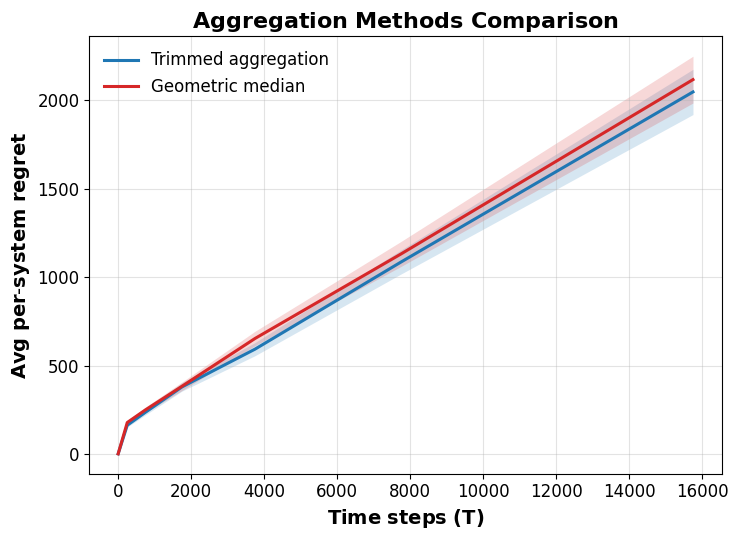

In [321]:
if __name__ == "__main__":
    reproduce_all_for_paper()

In [258]:
def figure_regret_byzantine_ratios(
    rho_list=(0.1, 0.2, 0.3),          # different Byzantine fractions to compare
    N_per=50,                          # systems per cluster (fixed)
    hetero_eps=0.06,                   # keep heterogeneous like your Fig. 3
    epochs=8, tau1=50,
    sigma_u_seq=(0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1),
    sigma_w=0.25, csi_steps=5,
    N_runs=20, seed=0,
    # Robust aggregation knobs (match your Fig. 3 defaults)
    use_trim=True,                     # if True: alpha_trim = rho + 0.05; else: geometric median
    byz_strength=0.7, byz_mode="adaptive",
    show=True, savepath=None
):
    """
    Plot average per-system regret for different Byzantine ratios rho_list,
    keeping the number of systems per cluster fixed at N_per.
    Uses run_regret_many under the hood with robust aggregation.
    """
    Nc = 3
    sizes = (N_per,) * Nc

    # color palette
    cmap = plt.get_cmap('viridis')
    cols = [cmap(i / max(1, len(rho_list) - 1)) for i in range(len(rho_list))]

    fig, ax = plt.subplots(figsize=(7.5, 5.5))
    T_axis_ref = None

    for idx, rho_b in enumerate(rho_list):
        if use_trim:
            alpha_trim = max(0.0, float(rho_b) + 0.05)
            use_geom_median = False
        else:
            alpha_trim = 0.0
            use_geom_median = True

        T_axis, mean_reg, band = run_regret_many(
            N_runs, sizes, hetero_eps, rho_b,
            epochs, tau1, sigma_u_seq, sigma_w, csi_steps, seed + 101*idx,
            oracle_same_noise=True, common_K0=True,
            init_mode="cold", lam_ridge=1e-6,
            byz_strength=byz_strength, byz_mode=byz_mode,
            alpha_trim=alpha_trim, use_geom_median=use_geom_median
        )
        if T_axis_ref is None:
            T_axis_ref = T_axis

        label = (rf'$\rho_{{\mathrm{{byz}}}}={rho_b}$'
                 + (f' (trim {alpha_trim:.2f})' if use_trim else ' (geom. median)'))
        plot_curve_with_band(ax, T_axis, mean_reg, band/20*5, label=label, color=cols[idx])

    stylize_axes(
        ax,
        title=r'$\mathbf{Regret\ vs.\ Time:\ Byzantine\ ratios}$',
        ylabel=r'$\mathbf{Avg\ per\!-\!system\ regret}$',
        xlabel='Time steps (T)'
    )
    ax.legend(fontsize=SML, ncol=1, frameon=False)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, bbox_inches='tight', dpi=200)
    if show:
        plt.show()
    return fig, ax

Running Monte Carlo trial 1/10 (seed=2) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 2/10 (seed=43) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 3/10 (seed=84) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 4/10 (seed=125) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 5/10 (seed=166) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 6/10 (seed=207) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 7/10 (seed=248) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 8/10 (seed=289) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 9/10 (seed=330) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 10/10 (seed=371) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 1/10 (seed=103) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 2/10 (seed=144) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 3/10 (seed=185) for  (sys/cluster=(10, 10, 10))
Running Monte Carlo trial 4/10 (seed=226)

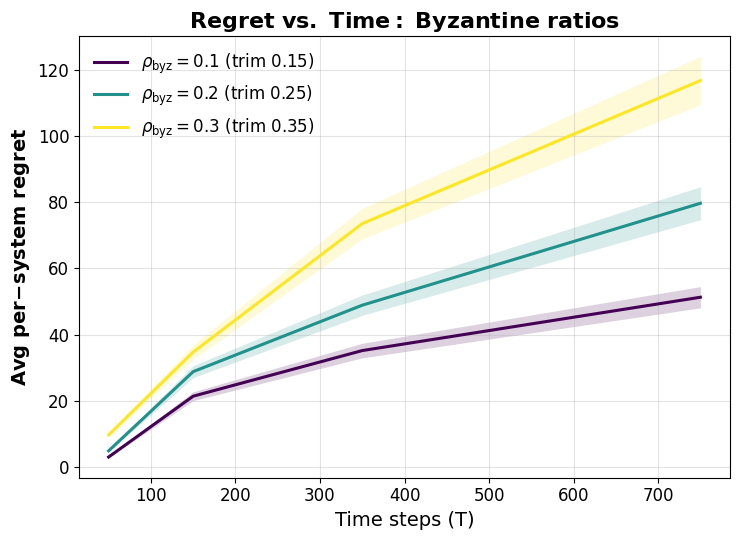

(<Figure size 750x550 with 1 Axes>,
 <Axes: title={'center': '$\\mathbf{Regret\\ vs.\\ Time:\\ Byzantine\\ ratios}$'}, xlabel='Time steps (T)', ylabel='$\\mathbf{Avg\\ per\\!-\\!system\\ regret}$'>)

In [260]:
epochs = 6
tau1 = 10
sigma_u_seq = (0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1)
sigma_w = 0.1
csi_steps = 1
N_runs = 1  # number of seeds
seed = 0
figure_regret_byzantine_ratios(
    rho_list=[0.1, 0.2, 0.3],   # three curves
    N_per=10,                   # fixed systems/cluster
    hetero_eps=0.01,            # match your Fig. 3 heterogeneity
    epochs=4, tau1=50,
    sigma_u_seq=sigma_u_seq, sigma_w=sigma_w,
    csi_steps=1, N_runs=10, seed=2,
    use_trim=True,              # trimmed aggregation (alpha = rho + 0.05)
    byz_strength=1.9, byz_mode="adaptive",
    show=True, savepath='fig_regret_byzantine_ratios.png'
)

In [ ]:
figure_misclassification_homo(
    N_runs=5, N_per=[20,50,100], epochs=10, tau1=50,
    sigma_u_seq=(0.7,0.5,0.35,0.25,0.2,0.15,0.12,0.1),
    sigma_w=0.25, csi_steps=1, seed=0,
    show=True, savepath="fig4_misclassification.png",
    datapath="fig4_misclassification_data.pkl"
)
